<a href="https://colab.research.google.com/github/Frostbite22/learning-DL-by-doing-2/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data preprocessing

In [3]:
from google.colab import drive

drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/PyTorch/learning_DL2/")

Mounted at /content/drive


In [4]:
import zipfile
from pathlib import Path

data_path = Path('/data')
image_path = data_path / "images"

if image_path.is_dir():
  print(f'{image_path} directory already exists')
else:
  print(f"{image_path} doesn't exist, creating one ...")
  image_path.mkdir(parents=True,exist_ok=True)

with zipfile.ZipFile('hymenoptera_data.zip','r') as zip_ref:
  zip_ref.extractall(image_path)

/data/images doesn't exist, creating one ...


In [5]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


In [6]:
walk_through_dir(image_path)

There are 1 directories and 0 images in /data/images
There are 2 directories and 0 images in /data/images/hymenoptera_data
There are 2 directories and 0 images in /data/images/hymenoptera_data/val
There are 0 directories and 70 images in /data/images/hymenoptera_data/val/ants
There are 0 directories and 83 images in /data/images/hymenoptera_data/val/bees
There are 2 directories and 0 images in /data/images/hymenoptera_data/train
There are 0 directories and 124 images in /data/images/hymenoptera_data/train/ants
There are 0 directories and 121 images in /data/images/hymenoptera_data/train/bees


In [7]:
os.getcwd()

'/content/drive/MyDrive/PyTorch/learning_DL2'

In [8]:
train_dir = image_path / "hymenoptera_data/train"
val_dir = image_path / "hymenoptera_data/val"


random img path: /data/images/hymenoptera_data/train/bees/1295655112_7813f37d21.jpg
image class : bees
Image height: 333
image width: 500


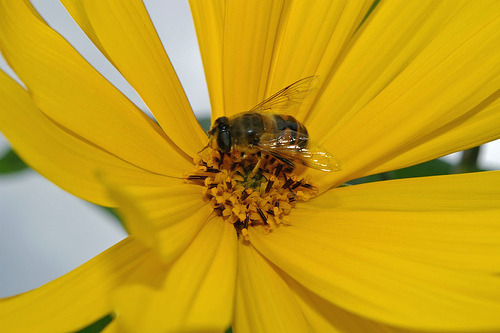

In [9]:
#Visualizing an image  
import random 
from PIL import Image 

# set seed 
random.seed(42)

#1. get all image paths 
image_path_list = list(image_path.glob("*/*/*/*.jpg"))
#2. pick a random image path 
random_image_path = random.choice(image_path_list)
#3. get image class from the path name(is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
#4. open image 
img = Image.open(random_image_path)
#5. print metadata 
print(f"random img path: {random_image_path}")
print(f"image class : {image_class}")
print(f"Image height: {img.height}")
print(f"image width: {img.width}")
img

Text(0.5, 1.0, 'image class : bees | Image Shape : (333, 500, 3) -> [height,width,color_channels]')

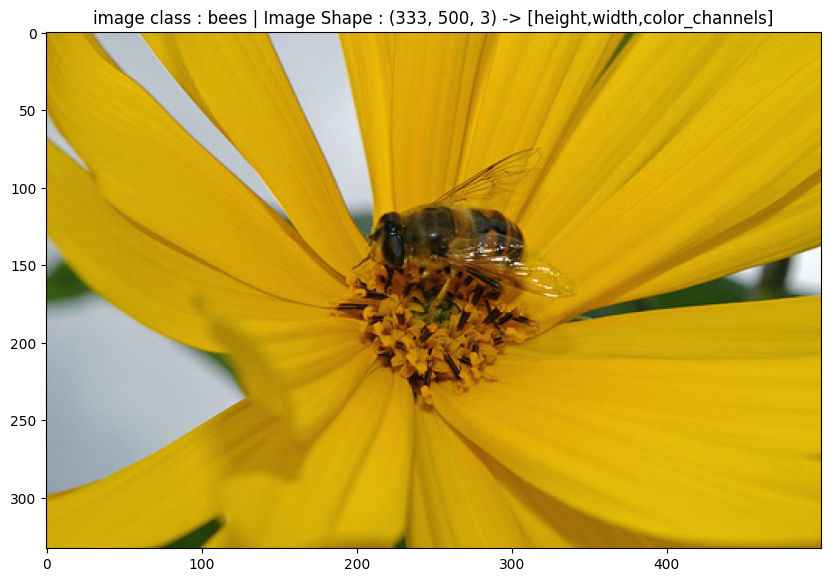

In [10]:
import numpy as np 
import matplotlib.pyplot as plt 

#Turn image to an array 
image_as_array = np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(image_as_array)
plt.title(f"image class : {image_class} | Image Shape : {image_as_array.shape} -> [height,width,color_channels]")

## Data Transform, Create train and validation datasets, create DataLoaders

In [11]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

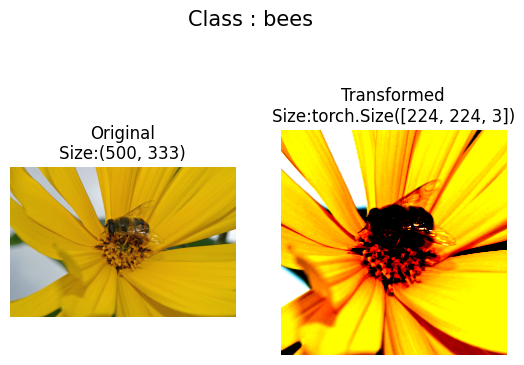

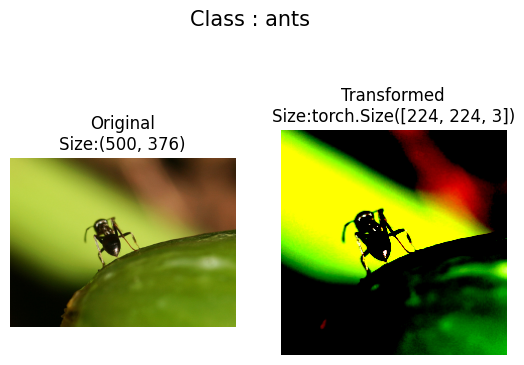

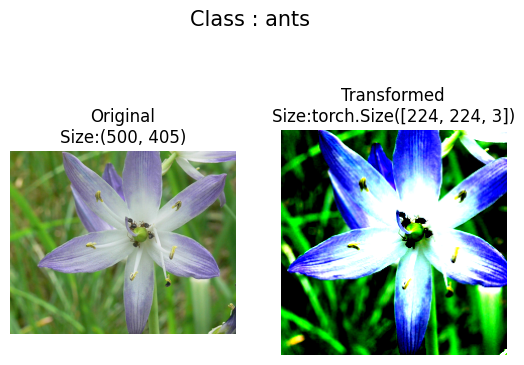

In [12]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths: 
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)
      ## transformed image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize:{transformed_image.shape}")
      ax[1].axis(False)
      fig.suptitle(f'Class : {image_path.parent.stem}',fontsize=15)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transforms['val'])

In [13]:
train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(root=val_dir,
                                     transform=data_transforms['val'])

In [14]:
len(train_dataset),len(val_dataset)

(244, 153)

In [15]:
class_names = train_dataset.classes
class_names

['ants', 'bees']

In [16]:
img,label = train_dataset[0]

Text(0.5, 1.0, "the label of this image is ants and it's shape is torch.Size([3, 224, 224]) -> [color_channels,width,height]")

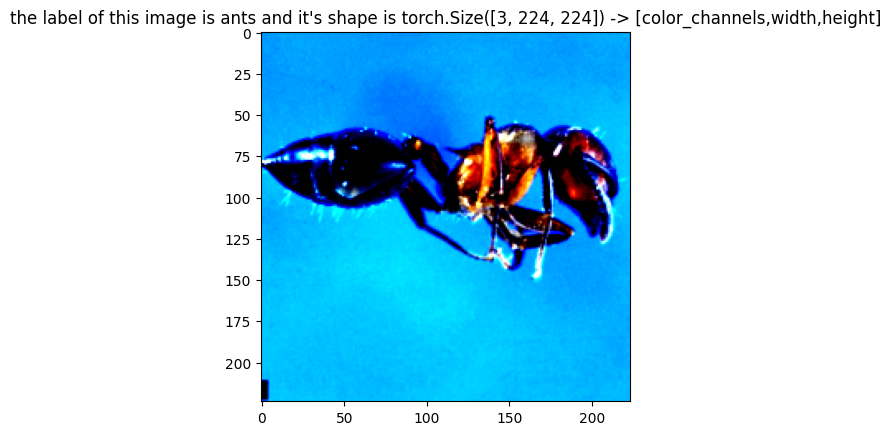

In [17]:
plt.imshow(img.permute(1,2,0))
plt.title(f"the label of this image is {class_names[label]} and it's shape is {img.shape} -> [color_channels,width,height]")

In [18]:
img, label = val_dataset[0]

Text(0.5, 1.0, "the label of this image is ants and it's shape is torch.Size([3, 224, 224]) -> [color_channels,width,height]")

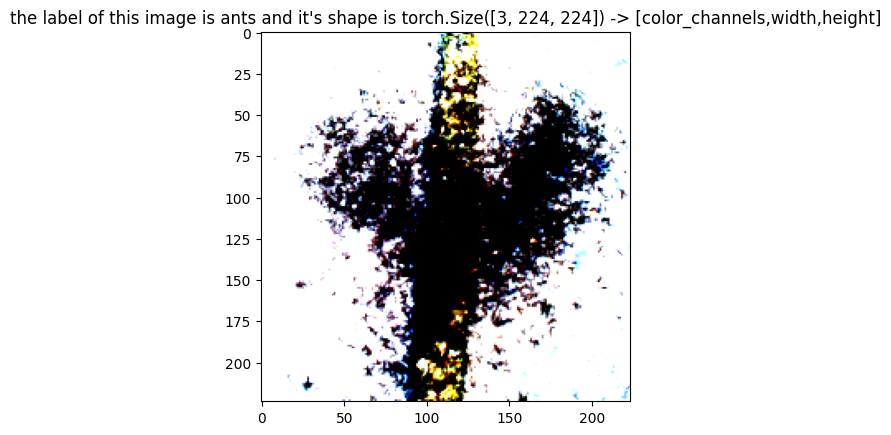

In [19]:
plt.imshow(img.permute(1,2,0))
plt.title(f"the label of this image is {class_names[label]} and it's shape is {img.shape} -> [color_channels,width,height]")

In [20]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=1)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=1)


dataloaders = {'train': DataLoader(dataset=train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=1),
               'val' : DataLoader(dataset=val_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=1)}

dataset_sizes = {'train': len(train_dataset),
                 'val' : len(val_dataset)}


In [21]:
len(train_dataloader), len(val_dataloader)

(61, 39)

In [22]:
img, label = next(iter(train_dataloader))

print(f'Image Shape: {img.shape} -> [batch_size,color_channels,height,width]')
print(f'Label Shape: {label.shape}')

Image Shape: torch.Size([4, 3, 224, 224]) -> [batch_size,color_channels,height,width]
Label Shape: torch.Size([4])


## Traing and validation loop in one function but messy

In [ ]:
import time
import copy 
from torch.optim import lr_scheduler
from torchvision import models

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.5052 Acc: 0.7295
val Loss: 0.1790 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5306 Acc: 0.7746
val Loss: 0.2487 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4250 Acc: 0.8238
val Loss: 0.2187 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4262 Acc: 0.8197
val Loss: 0.4453 Acc: 0.8301

Epoch 4/24
----------
train Loss: 0.6705 Acc: 0.7336
val Loss: 0.2292 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4733 Acc: 0.8074
val Loss: 0.3872 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.5217 Acc: 0.7910
val Loss: 0.6908 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.5588 Acc: 0.7869
val Loss: 0.2090 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.4540 Acc: 0.8238
val Loss: 0.1869 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.4550 Acc: 0.8566
val Loss: 0.2712 Acc: 0.8758

Epoch 10/24
----------
train Loss: 0.3991 Acc: 0.8279
val Loss: 0.2024 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3403 Acc: 0.8566
val Loss: 0.1898 Acc: 0.9085

Ep

## Refactored training and validation loops

In [23]:
# This function is the training function of a model : training time
from torch import nn
def train_loop(model : nn.Module,
          optimizer : torch.optim.Optimizer,
          train_dataloader : DataLoader,
          loss_fn : nn.Module,
          scheduler : torch.optim.lr_scheduler,
          device = device):
  model.train()
  accuracy = 0
  train_loss = 0
  for batch,(X,y) in enumerate(train_dataloader):
    X,y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item() 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    _ , y_pred_class = torch.max(y_pred,1)
    accuracy += (y == y_pred_class).sum().item()/len(y_pred)

  scheduler.step()
  train_loss = train_loss/len(train_dataloader)
  accuracy = accuracy /len(train_dataloader)


  return accuracy, train_loss

In [24]:
#This function is the validation function : inference time 
def validation_loop(model : nn.Module,
                    optimizer : torch.optim.Optimizer,
                    val_dataloader : DataLoader,
                    loss_fn : nn.Module,
                    device = device):
  model.eval()
  accuracy = 0 
  val_loss = 0 
  with torch.inference_mode():
    for batch, (X,y) in enumerate(val_dataloader):
      X,y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred,y)
      val_loss += loss.item() 
      _ , y_pred_class = torch.max(y_pred,1)
      accuracy += (y_pred_class==y).sum()/len(y_pred_class)
  
  val_loss = val_loss / len(val_dataloader)
  accuracy = accuracy / len(val_dataloader)
  return accuracy, val_loss
  


In [25]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import copy
from tqdm import tqdm
# This is training + inference
def train(model : nn.Module,
          train_dataloader : torch.utils.data.DataLoader,
          val_dataloader : torch.utils.data.DataLoader,
          num_epochs : int,
          optimizer : torch.optim.Optimizer,
          loss_fn : nn.Module,
          scheduler : torch.optim.lr_scheduler,
          device = device):
  results = {
      "train_acc" : [],
      "train_loss" : [], 
      "val_acc" : [],
      "val_loss": []
  }

  best_model_weights = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in tqdm(range(num_epochs)):
    train_acc,train_loss = train_loop(model=model,
                                      optimizer=optimizer,
                                      train_dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      scheduler=scheduler,
                                      device = device)
    
    val_acc, val_loss = validation_loop(model=model,
                                        optimizer=optimizer,
                                        val_dataloader=val_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)  
    print(f"\nEpoch {epoch+1}:")
    print(f"\nTrain accuracy : {train_acc : .4f} | Training loss : {train_loss : .4f}")
    print(f"validation accuracy : {val_acc : .4f} | validation loss : {val_loss : .4f} ")
    print('-'*100)
    results["train_acc"].append(train_acc)
    results["train_loss"].append(train_loss)
    results["val_acc"].append(val_acc)
    results["val_loss"].append(val_loss)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model_weights = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_weights)
  print(f"Best validation accuracy : { best_acc : .4f}")

  return model
    


In [27]:
# Transfer learning part : finetuning the model 
# Load a pretrained model and reset final fully connected layer.

from timeit import default_timer as timer
from torch.optim import lr_scheduler
from torchvision import models


NUM_EPOCHS = 25

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features 
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(),lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

start = timer()
model_ft = train(model=model_ft,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 optimizer=optimizer,
                 scheduler=exp_lr_scheduler,
                 loss_fn= criterion,
                 num_epochs=NUM_EPOCHS,
                 device=device)

end = timer()

print(f"training time {end - start : .4f}")




/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  4%|▍         | 1/25 [00:11<04:29, 11.23s/it]


Epoch 1:

Train accuracy :  0.6516 | Training loss :  0.6418
validation accuracy :  0.8397 | validation loss :  0.4214 
----------------------------------------------------------------------------------------------------


  8%|▊         | 2/25 [00:15<02:43,  7.11s/it]


Epoch 2:

Train accuracy :  0.7418 | Training loss :  0.5074
validation accuracy :  0.8590 | validation loss :  0.3828 
----------------------------------------------------------------------------------------------------


 12%|█▏        | 3/25 [00:19<02:09,  5.91s/it]


Epoch 3:

Train accuracy :  0.7869 | Training loss :  0.4538
validation accuracy :  0.9038 | validation loss :  0.2811 
----------------------------------------------------------------------------------------------------


 16%|█▌        | 4/25 [00:23<01:44,  4.99s/it]


Epoch 4:

Train accuracy :  0.8443 | Training loss :  0.3778
validation accuracy :  0.9423 | validation loss :  0.2341 
----------------------------------------------------------------------------------------------------


 20%|██        | 5/25 [00:27<01:29,  4.49s/it]


Epoch 5:

Train accuracy :  0.8074 | Training loss :  0.4248
validation accuracy :  0.9231 | validation loss :  0.2255 
----------------------------------------------------------------------------------------------------


 24%|██▍       | 6/25 [00:32<01:29,  4.71s/it]


Epoch 6:

Train accuracy :  0.7787 | Training loss :  0.4177
validation accuracy :  0.9103 | validation loss :  0.2295 
----------------------------------------------------------------------------------------------------


 28%|██▊       | 7/25 [00:35<01:18,  4.36s/it]


Epoch 7:

Train accuracy :  0.8361 | Training loss :  0.3917
validation accuracy :  0.9103 | validation loss :  0.2232 
----------------------------------------------------------------------------------------------------


 32%|███▏      | 8/25 [00:39<01:10,  4.12s/it]


Epoch 8:

Train accuracy :  0.8402 | Training loss :  0.3792
validation accuracy :  0.9038 | validation loss :  0.2305 
----------------------------------------------------------------------------------------------------


 36%|███▌      | 9/25 [00:44<01:10,  4.39s/it]


Epoch 9:

Train accuracy :  0.8197 | Training loss :  0.3894
validation accuracy :  0.9167 | validation loss :  0.2199 
----------------------------------------------------------------------------------------------------


 40%|████      | 10/25 [00:48<01:02,  4.15s/it]


Epoch 10:

Train accuracy :  0.8320 | Training loss :  0.3648
validation accuracy :  0.9167 | validation loss :  0.2112 
----------------------------------------------------------------------------------------------------


 44%|████▍     | 11/25 [00:51<00:55,  3.98s/it]


Epoch 11:

Train accuracy :  0.8402 | Training loss :  0.3499
validation accuracy :  0.9423 | validation loss :  0.1958 
----------------------------------------------------------------------------------------------------


 48%|████▊     | 12/25 [00:55<00:52,  4.01s/it]


Epoch 12:

Train accuracy :  0.8320 | Training loss :  0.3679
validation accuracy :  0.9167 | validation loss :  0.2250 
----------------------------------------------------------------------------------------------------


 52%|█████▏    | 13/25 [01:00<00:50,  4.21s/it]


Epoch 13:

Train accuracy :  0.8238 | Training loss :  0.3716
validation accuracy :  0.9231 | validation loss :  0.2111 
----------------------------------------------------------------------------------------------------


 56%|█████▌    | 14/25 [01:04<00:44,  4.03s/it]


Epoch 14:

Train accuracy :  0.8525 | Training loss :  0.3359
validation accuracy :  0.9038 | validation loss :  0.2132 
----------------------------------------------------------------------------------------------------


 60%|██████    | 15/25 [01:07<00:39,  3.93s/it]


Epoch 15:

Train accuracy :  0.8607 | Training loss :  0.3404
validation accuracy :  0.9231 | validation loss :  0.2086 
----------------------------------------------------------------------------------------------------


 64%|██████▍   | 16/25 [01:13<00:39,  4.34s/it]


Epoch 16:

Train accuracy :  0.8238 | Training loss :  0.3634
validation accuracy :  0.9167 | validation loss :  0.2350 
----------------------------------------------------------------------------------------------------


 68%|██████▊   | 17/25 [01:16<00:32,  4.11s/it]


Epoch 17:

Train accuracy :  0.8525 | Training loss :  0.3235
validation accuracy :  0.9167 | validation loss :  0.2202 
----------------------------------------------------------------------------------------------------


 72%|███████▏  | 18/25 [01:20<00:27,  3.98s/it]


Epoch 18:

Train accuracy :  0.8566 | Training loss :  0.3392
validation accuracy :  0.9295 | validation loss :  0.2126 
----------------------------------------------------------------------------------------------------


 76%|███████▌  | 19/25 [01:25<00:25,  4.30s/it]


Epoch 19:

Train accuracy :  0.8566 | Training loss :  0.3300
validation accuracy :  0.9167 | validation loss :  0.2213 
----------------------------------------------------------------------------------------------------


 80%|████████  | 20/25 [01:29<00:20,  4.12s/it]


Epoch 20:

Train accuracy :  0.8811 | Training loss :  0.2913
validation accuracy :  0.9167 | validation loss :  0.2178 
----------------------------------------------------------------------------------------------------


 84%|████████▍ | 21/25 [01:32<00:15,  4.00s/it]


Epoch 21:

Train accuracy :  0.8074 | Training loss :  0.3623
validation accuracy :  0.9295 | validation loss :  0.2069 
----------------------------------------------------------------------------------------------------


 88%|████████▊ | 22/25 [01:37<00:12,  4.09s/it]


Epoch 22:

Train accuracy :  0.8566 | Training loss :  0.3444
validation accuracy :  0.9167 | validation loss :  0.2058 
----------------------------------------------------------------------------------------------------


 92%|█████████▏| 23/25 [01:41<00:08,  4.17s/it]


Epoch 23:

Train accuracy :  0.8934 | Training loss :  0.3127
validation accuracy :  0.9103 | validation loss :  0.2135 
----------------------------------------------------------------------------------------------------


 96%|█████████▌| 24/25 [01:44<00:03,  3.99s/it]


Epoch 24:

Train accuracy :  0.8730 | Training loss :  0.2977
validation accuracy :  0.9103 | validation loss :  0.2253 
----------------------------------------------------------------------------------------------------


100%|██████████| 25/25 [01:48<00:00,  4.35s/it]


Epoch 25:

Train accuracy :  0.8811 | Training loss :  0.3350
validation accuracy :  0.9103 | validation loss :  0.2383 
----------------------------------------------------------------------------------------------------
Best validation accuracy :  0.9423
training time  108.7129


In [28]:
# ConvNet as fixed feature extractor
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default 
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.parameters(),lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

start = timer()
model_conv = train(model=model_conv,
                 train_dataloader=train_dataloader,
                 val_dataloader=val_dataloader,
                 optimizer=optimizer,
                 scheduler=exp_lr_scheduler,
                 loss_fn= criterion,
                 num_epochs=NUM_EPOCHS,
                 device=device)

end = timer()

print(f"training time {end - start : .4f}")


  4%|▍         | 1/25 [00:05<02:02,  5.11s/it]


Epoch 1:

Train accuracy :  0.5656 | Training loss :  0.6897
validation accuracy :  0.7308 | validation loss :  0.5757 
----------------------------------------------------------------------------------------------------


  8%|▊         | 2/25 [00:08<01:36,  4.20s/it]


Epoch 2:

Train accuracy :  0.7295 | Training loss :  0.5757
validation accuracy :  0.7500 | validation loss :  0.5132 
----------------------------------------------------------------------------------------------------


 12%|█▏        | 3/25 [00:12<01:25,  3.91s/it]


Epoch 3:

Train accuracy :  0.7500 | Training loss :  0.5533
validation accuracy :  0.9103 | validation loss :  0.3864 
----------------------------------------------------------------------------------------------------


 16%|█▌        | 4/25 [00:17<01:29,  4.28s/it]


Epoch 4:

Train accuracy :  0.7910 | Training loss :  0.4858
validation accuracy :  0.8590 | validation loss :  0.3982 
----------------------------------------------------------------------------------------------------


 20%|██        | 5/25 [00:20<01:22,  4.11s/it]


Epoch 5:

Train accuracy :  0.7623 | Training loss :  0.4902
validation accuracy :  0.9359 | validation loss :  0.3187 
----------------------------------------------------------------------------------------------------


 24%|██▍       | 6/25 [00:27<01:35,  5.04s/it]


Epoch 6:

Train accuracy :  0.8074 | Training loss :  0.4442
validation accuracy :  0.9423 | validation loss :  0.2936 
----------------------------------------------------------------------------------------------------


 28%|██▊       | 7/25 [00:36<01:49,  6.11s/it]


Epoch 7:

Train accuracy :  0.8074 | Training loss :  0.4390
validation accuracy :  0.9359 | validation loss :  0.2721 
----------------------------------------------------------------------------------------------------


 32%|███▏      | 8/25 [00:39<01:29,  5.29s/it]


Epoch 8:

Train accuracy :  0.8443 | Training loss :  0.3982
validation accuracy :  0.9359 | validation loss :  0.2701 
----------------------------------------------------------------------------------------------------


 36%|███▌      | 9/25 [00:44<01:21,  5.08s/it]


Epoch 9:

Train accuracy :  0.7746 | Training loss :  0.4448
validation accuracy :  0.9423 | validation loss :  0.2670 
----------------------------------------------------------------------------------------------------


 40%|████      | 10/25 [00:48<01:10,  4.69s/it]


Epoch 10:

Train accuracy :  0.8443 | Training loss :  0.4138
validation accuracy :  0.9359 | validation loss :  0.2661 
----------------------------------------------------------------------------------------------------


 44%|████▍     | 11/25 [00:51<01:00,  4.34s/it]


Epoch 11:

Train accuracy :  0.7992 | Training loss :  0.4505
validation accuracy :  0.9359 | validation loss :  0.2717 
----------------------------------------------------------------------------------------------------


 48%|████▊     | 12/25 [00:55<00:53,  4.11s/it]


Epoch 12:

Train accuracy :  0.8115 | Training loss :  0.4210
validation accuracy :  0.9359 | validation loss :  0.2660 
----------------------------------------------------------------------------------------------------


 52%|█████▏    | 13/25 [00:59<00:51,  4.32s/it]


Epoch 13:

Train accuracy :  0.8607 | Training loss :  0.3831
validation accuracy :  0.9423 | validation loss :  0.2677 
----------------------------------------------------------------------------------------------------


 56%|█████▌    | 14/25 [01:03<00:44,  4.08s/it]


Epoch 14:

Train accuracy :  0.8320 | Training loss :  0.3860
validation accuracy :  0.9423 | validation loss :  0.2607 
----------------------------------------------------------------------------------------------------


 60%|██████    | 15/25 [01:07<00:39,  3.93s/it]


Epoch 15:

Train accuracy :  0.8402 | Training loss :  0.3897
validation accuracy :  0.9551 | validation loss :  0.2540 
----------------------------------------------------------------------------------------------------


 64%|██████▍   | 16/25 [01:11<00:37,  4.21s/it]


Epoch 16:

Train accuracy :  0.8525 | Training loss :  0.3813
validation accuracy :  0.9295 | validation loss :  0.2615 
----------------------------------------------------------------------------------------------------


 68%|██████▊   | 17/25 [01:15<00:32,  4.02s/it]


Epoch 17:

Train accuracy :  0.7992 | Training loss :  0.4153
validation accuracy :  0.9423 | validation loss :  0.2589 
----------------------------------------------------------------------------------------------------


 72%|███████▏  | 18/25 [01:19<00:27,  3.87s/it]


Epoch 18:

Train accuracy :  0.8156 | Training loss :  0.4112
validation accuracy :  0.9423 | validation loss :  0.2557 
----------------------------------------------------------------------------------------------------


 76%|███████▌  | 19/25 [01:22<00:23,  3.89s/it]


Epoch 19:

Train accuracy :  0.7910 | Training loss :  0.4436
validation accuracy :  0.9359 | validation loss :  0.2595 
----------------------------------------------------------------------------------------------------


 80%|████████  | 20/25 [01:27<00:20,  4.06s/it]


Epoch 20:

Train accuracy :  0.8402 | Training loss :  0.4306
validation accuracy :  0.9295 | validation loss :  0.2712 
----------------------------------------------------------------------------------------------------


 84%|████████▍ | 21/25 [01:30<00:15,  3.89s/it]


Epoch 21:

Train accuracy :  0.8033 | Training loss :  0.4155
validation accuracy :  0.9487 | validation loss :  0.2591 
----------------------------------------------------------------------------------------------------


 88%|████████▊ | 22/25 [01:34<00:11,  3.79s/it]


Epoch 22:

Train accuracy :  0.8074 | Training loss :  0.4246
validation accuracy :  0.9423 | validation loss :  0.2537 
----------------------------------------------------------------------------------------------------


 92%|█████████▏| 23/25 [01:39<00:08,  4.11s/it]


Epoch 23:

Train accuracy :  0.8648 | Training loss :  0.3765
validation accuracy :  0.9423 | validation loss :  0.2546 
----------------------------------------------------------------------------------------------------


 96%|█████████▌| 24/25 [01:42<00:03,  3.93s/it]


Epoch 24:

Train accuracy :  0.8115 | Training loss :  0.4054
validation accuracy :  0.9359 | validation loss :  0.2636 
----------------------------------------------------------------------------------------------------


100%|██████████| 25/25 [01:46<00:00,  4.26s/it]


Epoch 25:

Train accuracy :  0.8402 | Training loss :  0.4016
validation accuracy :  0.9487 | validation loss :  0.2505 
----------------------------------------------------------------------------------------------------
Best validation accuracy :  0.9551
training time  106.4552



## Visualize 



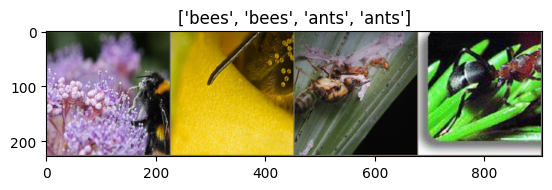

In [29]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [30]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [31]:
import random 
import math
def predict_visualize(model : nn.Module ,k : int = 6, nrows : int = 2 , ncols : int = 3):
  plt.figure(figsize=(15,10))
  for i,(sample, y) in enumerate(random.sample(list(val_dataset),k=k)):
    pred_logit = model(sample.to(device).unsqueeze(0))
    _ , pred = torch.max(pred_logit,1)

    plt.subplot(nrows,ncols,i+1)
    plt.imshow(sample.permute(1,2,0).numpy().astype("uint8"))
    truth_label = class_names[y]
    pred_label = class_names[pred.cpu()]
    title_text = f"Truth : {truth_label} | Pred : {pred_label}"
    if truth_label == pred_label: 
      plt.title(title_text,fontsize=10,c='g')
    else: 
      plt.title(title_text,fontsize=10,c='r')
    plt.axis(False)

  

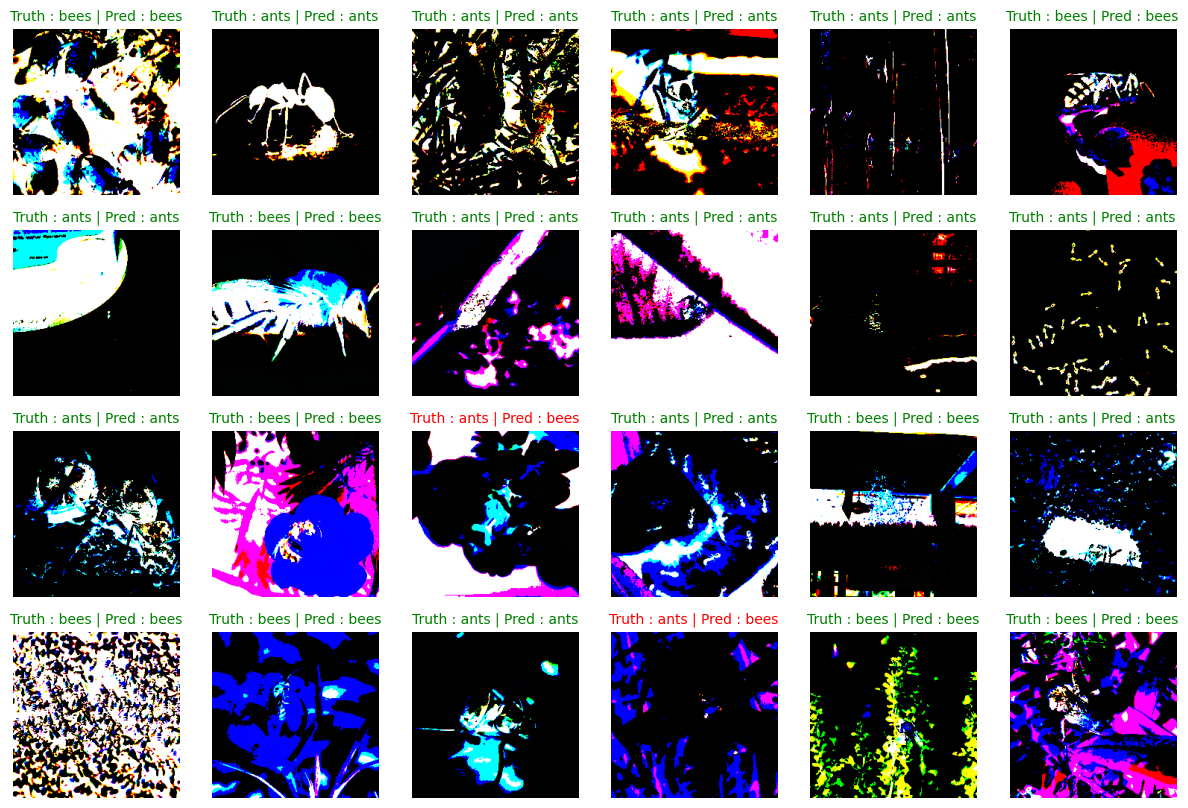

In [32]:
predict_visualize(k=24,nrows=4,ncols=6,model=model_ft)

## Stochastic Weighted Average

In [74]:
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data.dataloader import default_collate


# the new collate function is quite generic
loader = DataLoader(dataset=train_dataloader.dataset,collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.parameters(),lr=0.001)
swa_model = AveragedModel(model_conv)
scheduler = CosineAnnealingLR(optimizer, T_max=100)
swa_start = 5
swa_scheduler = SWALR(optimizer, swa_lr=0.05)
swa_model = swa_model.to(device)


for epoch in tqdm(range(100)):
      for input, target in loader:
          optimizer.zero_grad()
          loss_fn(model_conv(input), target).backward()
          optimizer.step()
      if epoch > swa_start:
          swa_model.update_parameters(model_conv)
          swa_scheduler.step()
      else:
          scheduler.step()


100%|██████████| 100/100 [04:40<00:00,  2.80s/it]


In [75]:
# Update bn statistics for the swa_model at the end
torch.optim.swa_utils.update_bn(loader, swa_model)

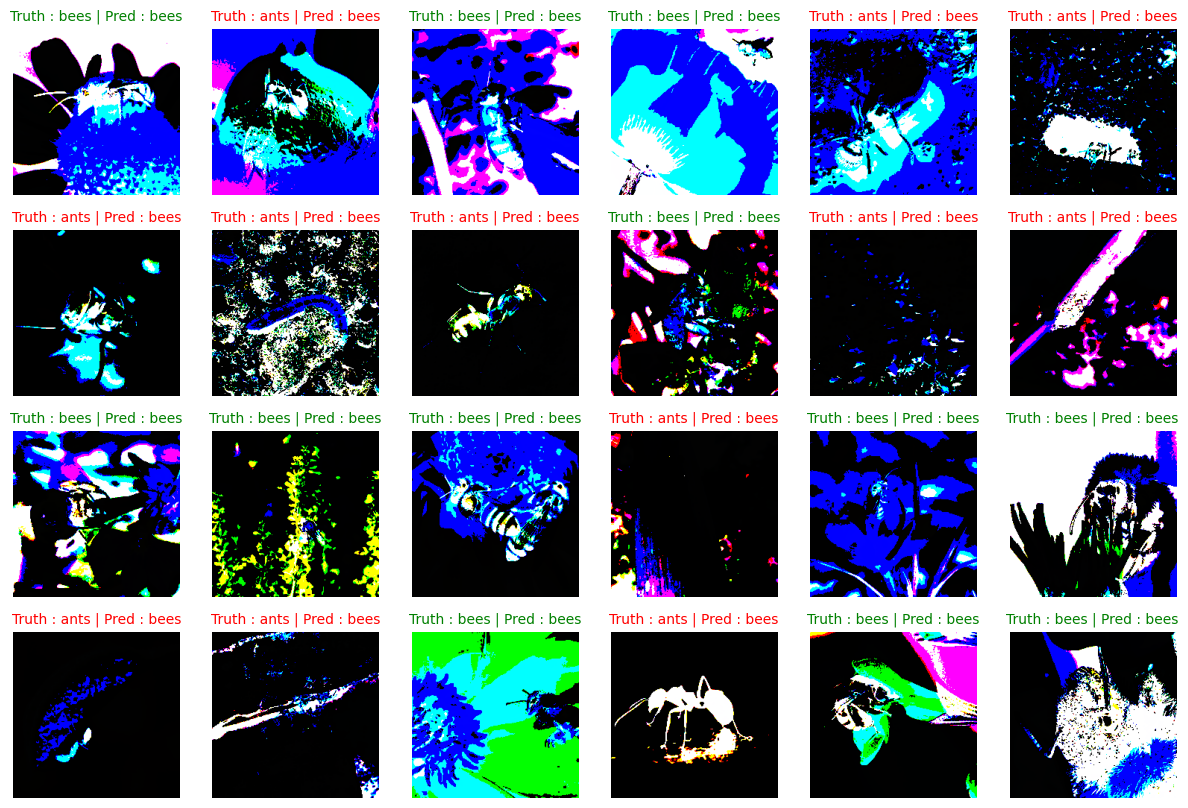

In [76]:
predict_visualize(k=24,nrows=4,ncols=6,model=swa_model)